# Google Images Classifier with fastai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
import os
import numpy as np
import pandas as pd

from glob import glob
from pathlib import Path
from collections import Counter

import torch

from tqdm.auto import tqdm
from tqdm import tqdm_notebook
tqdm.pandas()

from fastai.basic_data import DatasetType
from fastai.metrics import error_rate, accuracy
from fastai.vision import models as vision_models
from fastai.vision import download_images, verify_images
from fastai.vision import ClassificationInterpretation, ImageDataBunch, imagenet_stats, cnn_learner
from fastai.widgets import ImageCleaner, DatasetFormatter

In [2]:
NUM_CORES = 4
CSV_DATA_PATH = Path(os.path.join('data', 'casino'))
IMAGE_DATA_PATH = CSV_DATA_PATH/'images'

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [ ]:
# https://docs.fast.ai/vision.data.html#Building-your-own-dataset

classes = ['craps', 'roulette', 'blackjack']
for class_ in classes:
    data_path = IMAGE_DATA_PATH/class_
    data_path.mkdir(parents=True, exist_ok=True)
    download_images(CSV_DATA_PATH/class_, data_path, max_pics=256)

In [15]:
classes = ['craps', 'roulette', 'blackjack']
for class_ in classes:
    data_path = IMAGE_DATA_PATH/class_
    verify_images(data_path, delete=True, max_size=512)

### Create Dataset

In [3]:
classes = ['craps', 'roulette', 'blackjack']

In [4]:
dataset = ImageDataBunch.from_folder(IMAGE_DATA_PATH, train='.', valid_pct=0.2, seed=21, size=224, num_workers=4).normalize(imagenet_stats)

In [5]:
dataset

ImageDataBunch;

Train: LabelList (541 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
craps,craps,craps,craps,craps
Path: data/casino/images;

Valid: LabelList (135 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
blackjack,blackjack,craps,blackjack,roulette
Path: data/casino/images;

Test: None

In [6]:
dataset.classes

['blackjack', 'craps', 'roulette']

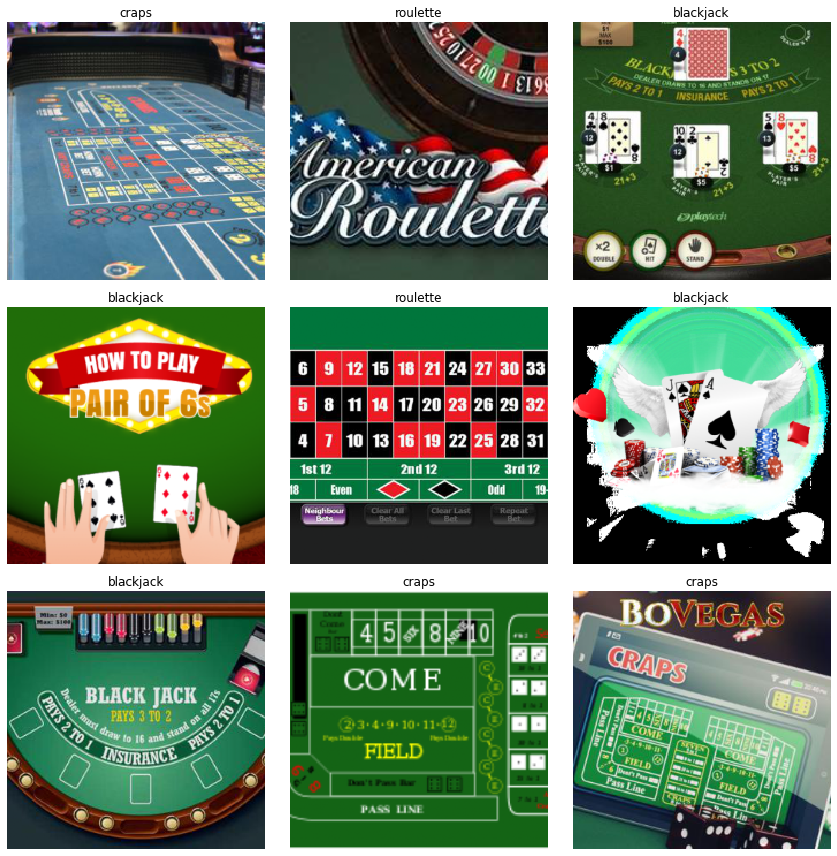

In [7]:
dataset.show_batch(rows=3, fig_size=(3, 3))

In [8]:
dataset.c

3

### Training Model

In [9]:
learn = cnn_learner(dataset, vision_models.resnet34, metrics=[error_rate])

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.494553,0.273171,0.088889,00:08
1,0.857744,0.273497,0.074074,00:05
2,0.584896,0.255926,0.081481,00:05
3,0.449855,0.252822,0.088889,00:05


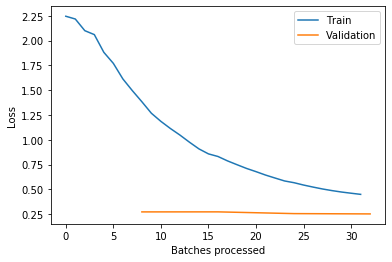

In [11]:
learn.recorder.plot_losses()

In [12]:
learn.save('resnet34', return_path=True)

PosixPath('data/casino/images/models/resnet34.pth')

### Optimizing Learning rate

In [13]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<img src="data/casino/lr_find.PNG" />

Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


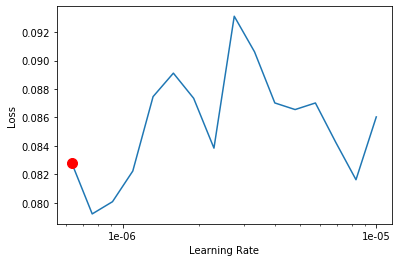

In [14]:
learn.recorder.plot(suggestion=True)

In [15]:
print("From: {:.20f}".format(6.31E-07), "To: {:.20f}".format(3e-4))

From: 0.00000063100000000000 To: 0.00029999999999999997


In [16]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1.10E-06, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.095168,0.236067,0.074074,00:07
1,0.073059,0.209149,0.074074,00:07
2,0.060378,0.203401,0.059259,00:07
3,0.053346,0.204234,0.059259,00:07


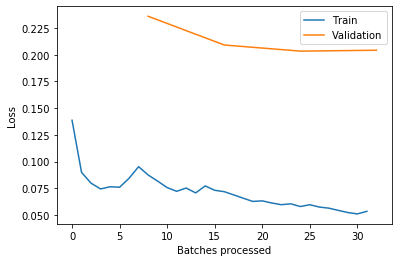

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.save('resnet34', return_path=True)

PosixPath('data/casino/images/models/resnet34.pth')

### Interpretation

In [19]:
learn = cnn_learner(dataset, vision_models.resnet34, metrics=[error_rate])
learn.load('resnet34');

In [20]:
cls_interpreter = ClassificationInterpretation.from_learner(learn)

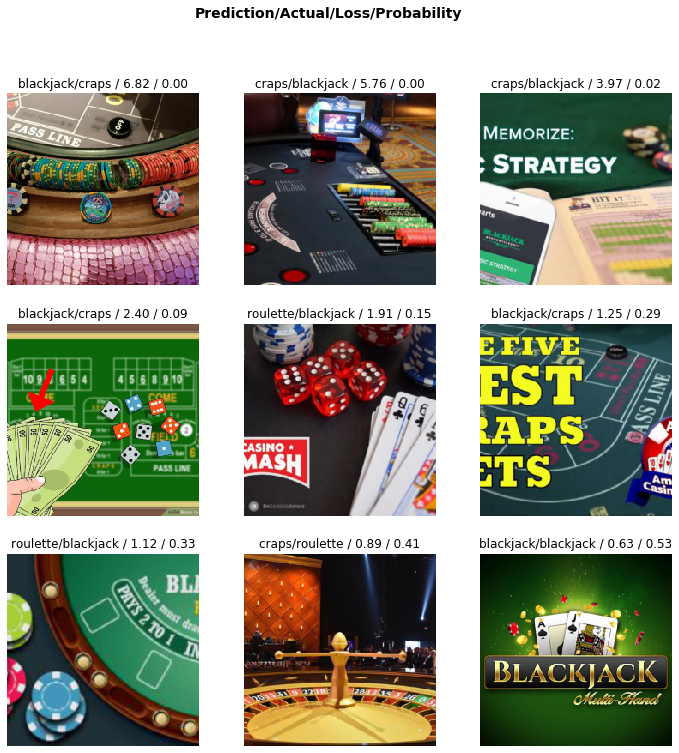

In [21]:
cls_interpreter.plot_top_losses(k=9, figsize=(12, 12))

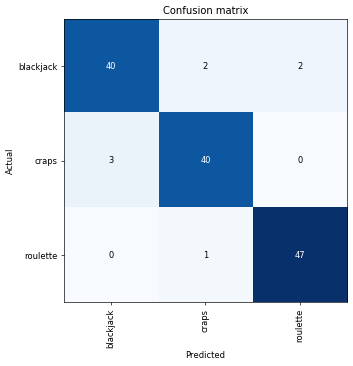

In [22]:
cls_interpreter.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [23]:
cls_interpreter.most_confused(min_val=1)

[('craps', 'blackjack', 3),
 ('blackjack', 'craps', 2),
 ('blackjack', 'roulette', 2),
 ('roulette', 'craps', 1)]

### Doing the cleanup using DataFormatter Widget

In [24]:
# Loading model with ImageDataBunch containing all images (i.e. without validation split)

dataset_all = ImageDataBunch.from_folder(IMAGE_DATA_PATH, train='.', valid_pct=0.0, size=224).normalize(imagenet_stats)
dataset_all

ImageDataBunch;

Train: LabelList (676 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
craps,craps,craps,craps,craps
Path: data/casino/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/casino/images;

Test: None

In [25]:
learn = cnn_learner(dataset_all, vision_models.resnet34, metrics=[error_rate])
learn.load('resnet34');

In [35]:
ds, indexes = DatasetFormatter.from_toplosses(learn)

In [37]:
ds

LabelList (676 items)
x: ImageList
Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
y: CategoryList
craps,craps,craps,craps,craps
Path: data/casino/images

In [38]:
ImageCleaner(ds, indexes, CSV_DATA_PATH)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [40]:
ds, indexes = DatasetFormatter().from_similars(learn)
ds

Getting activations...


Computing similarities...


LabelList (676 items)
x: ImageList
Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
y: CategoryList
craps,craps,craps,craps,craps
Path: data/casino/images

In [42]:
ImageCleaner(ds, indexes, CSV_DATA_PATH, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Re-Building Model after Cleanup

In [47]:
dataset_cleaned = ImageDataBunch.from_csv(CSV_DATA_PATH, folder='.', csv_labels='cleaned.csv', valid_pct=0.2, size=224).normalize(imagenet_stats)
dataset_cleaned

ImageDataBunch;

Train: LabelList (520 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
craps,craps,craps,craps,craps
Path: data/casino;

Valid: LabelList (129 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
craps,craps,roulette,roulette,craps
Path: data/casino;

Test: None

In [48]:
dataset.classes

['blackjack', 'craps', 'roulette']

In [49]:
learn = cnn_learner(dataset, vision_models.resnet34, metrics=[error_rate])

In [50]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.690365,0.552709,0.177778,00:05
1,1.027674,0.332303,0.096296,00:05
2,0.717548,0.288599,0.059259,00:05
3,0.526696,0.292895,0.059259,00:05
4,0.410802,0.278058,0.059259,00:05
5,0.324657,0.274076,0.059259,00:05


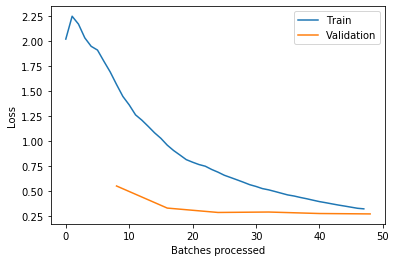

In [51]:
learn.recorder.plot_losses()

In [52]:
learn.save('resnet34', return_path=True)

PosixPath('data/casino/images/models/resnet34.pth')

In [54]:
learn.lr_find(start_lr=1e-5, end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-05
Min loss divided by 10: 7.59E-04


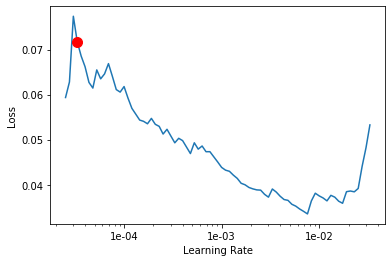

In [55]:
learn.recorder.plot(suggestion=True)

In [56]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(3.31E-05, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.089379,0.286874,0.059259,00:07
1,0.079444,0.358506,0.081481,00:07
2,0.068128,0.300093,0.044444,00:07
3,0.057651,0.277920,0.051852,00:07


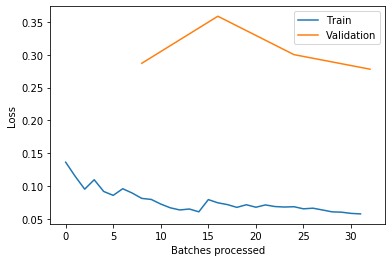

In [57]:
learn.recorder.plot_losses()

In [58]:
learn.save('resnet34', return_path=True)

PosixPath('data/casino/images/models/resnet34.pth')

In [59]:
cls_interpreter = ClassificationInterpretation.from_learner(learn)

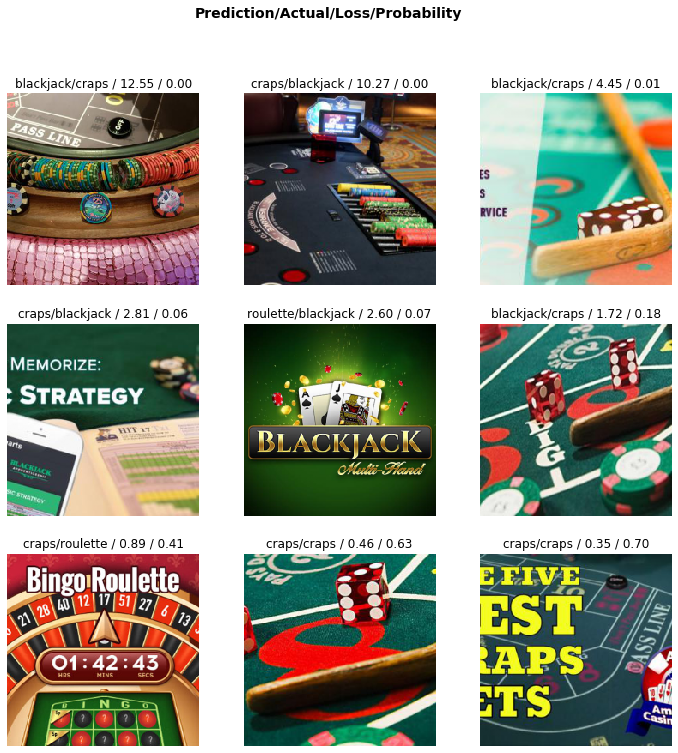

In [61]:
cls_interpreter.plot_top_losses(k=9, figsize=(12, 12))

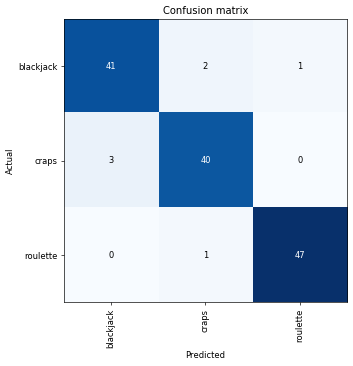

In [60]:
cls_interpreter.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Model in production

In [64]:
learn.export('resnet34_prod.pkl')

Deployment API code can be found in **lesson2_production.py**